In [1]:
from functools import partial

from transformers import CLIPVisionModel 
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
# import os
# proxy = 'http://127.0.0.1:7890'
# os.environ['http_proxy'] = proxy
# os.environ['https_proxy'] = proxy
# import subprocess
# import os

# result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
# output = result.stdout
# for line in output.splitlines():
#     if '=' in line:
#         var, value = line.split('=', 1)
#         os.environ[var] = value
import torch
import torch.nn as nn
from transformers import CLIPVisionModel
from torchvision import transforms
import sys
sys.path.append("../")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/envs/BCI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import transformers
print(transformers.__version__)

4.29.2


In [3]:
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

In [4]:
class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.clip = CLIPVisionModel.from_pretrained('openai/clip-vit-large-patch14').to(torch.bfloat16)
        # self.clip_size = (224, 224)

        self.preprocess = CLIPImageProcessor(
            # size={"height": 512, "width": 512},
            size={"shortest_edge": 512}, 
            crop_size={"height": 512, "width": 512},
        )


        # for param in self.clip.parameters():
        #     param.requires_grad = False
        self.image_encoder = CLIPVisionModelWithProjection.from_pretrained(
        "h94/IP-Adapter", 
        # "laion2b_s32b_b79k",
        subfolder="models/image_encoder",
        torch_dtype=torch.float16,
        ).to("cuda")
        
        
    
def encode_image(image, image_encoder, feature_extractor, num_images_per_prompt=1, device='cuda'):
    dtype = next(image_encoder.parameters()).dtype

    if not isinstance(image, torch.Tensor):
        image = feature_extractor(image, return_tensors="pt").pixel_values # [1, 3, 224, 224]
        print("image", image.shape)
    image = image.to(device=device, dtype=dtype)
    image_embeds = image_encoder(image).image_embeds # (1, 1024)
    image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0) # (num_images_per_prompt, 1024)   # 生成指定个数的图像嵌入

    return image_embeds

In [5]:
# example_image_path = "/root/autodl-tmp/Workspace/EEG_caption/docs/test/alpaca_03s.jpg"
clip_encoder = CLIPEncoder().to(device)

# from diffusers.utils import load_image
# image_prompt = load_image(example_image_path)
# display(image_prompt)


/opt/conda/envs/BCI/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
# image = Image.open(example_image_path).convert("RGB")
# image_embeds = encode_image(image_prompt, clip_encoder.image_encoder, clip_encoder.preprocess, 1, device)
# image_embeds.shape

In [7]:
import torch
# torch.save(image_embeds, 'image_embeds.pt')
image_embeds_1 = torch.load('/home/tom/fsas/eeg_data/ViT-H-14_features_test.pt', map_location=device)['img_features'].unsqueeze(1)

/tmp/ipykernel_1953/32227986.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeds_1 = torch.load('/home/tom/fsas/eeg_data/ViT-H-14_features_test.pt', map_locatio

In [8]:
image_embeds_1.shape

torch.Size([200, 1, 1024])

In [9]:
eeg_embeds_1 = torch.load('/home/tom/fsas/eeg_data/ATM_S_eeg_features_sub-08_test.pt', map_location=device).unsqueeze(1)


/tmp/ipykernel_1953/2482380811.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eeg_embeds_1 = torch.load('/home/tom/fsas/eeg_data/ATM_S_eeg_features_sub-08_test.pt', map

In [10]:
eeg_embeds_1.shape

torch.Size([200, 1, 1024])

In [11]:
# img_feature = img_feature.mean(dim=1).squeeze(0)
# img_feature = img_feature.unsqueeze(0)
# img_feature.shape

In [12]:
# open_clip_img_feature = torch.load('ViT-H-14_features_test.pt', map_location=device)['img_features'].unsqueeze(1)
# open_clip_img_feature[0].shape

In [13]:
# open_clip_img_feature[0].std()

In [14]:
# import torch
# image_features_test = torch.load("/home/ldy/Workspace/EEG_caption/ViT-H-14_features_test.pt")
# image_features_test['img_features'].shape

In [15]:
# image_features_test['img_features'][0].unsqueeze(0).shape

In [16]:
# import torch
# image_features_test = torch.load("/home/ldy/Workspace/BrainAligning/ViT-L-14_features_multimodal_test.pt")
# image_features_test['img_features'].shape

In [17]:

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# import open_clip
from matplotlib.font_manager import FontProperties


from diffusion_prior import *
from custom_pipeline_low_level import *
# from custom_pipeline import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/envs/BCI/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [18]:
image_embeds_1.shape

torch.Size([200, 1, 1024])

In [19]:
image_embeds_1[0].shape

torch.Size([1, 1024])

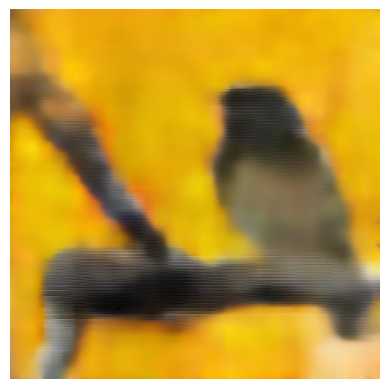

torch.Size([1, 3, 512, 512])

In [20]:
# from PIL import Image
# import matplotlib.pyplot as plt
index = 114 
low_level_img_path = f'/home/tom/fsas/eeg_data/generated_images/12-18_15-23_vae_train_imgs/epoch_199/reconstructed_image_{index}.png'
# # Provides low-level images 
low_level_image = Image.open(low_level_img_path)
# low_level_image.show()
plt.imshow(low_level_image)
plt.axis("off")  # 关闭坐标轴
plt.show()
low_level_image = clip_encoder.preprocess(low_level_image, return_tensors="pt").pixel_values # [1, 3, 224, 224]
low_level_image.shape

In [33]:
# from diffusers.image_processor import VaeImageProcessor
# image_processor = VaeImageProcessor()
# from diffusers import AutoencoderKL
# # path = "stabilityai/sdxl-turbo"
# # vlmodel = AutoencoderKL.from_pretrained(
# #     path, subfolder='vae').to(device)

# pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float, variant="fp16")
# vlmodel = pipe.vae

# posterior = vlmodel.encode(low_level_image).latent_dist   # latent_dist属性是latent的分布
# image_latent = posterior.mode()                           # 通过.mode()从分布中进行采样
# print("image_latent.shape", image_latent.shape)

In [34]:
# with torch.no_grad():
#     x_rec = vlmodel.decode(image_latent).sample
#     image_rec = image_processor.postprocess(x_rec, output_type='pil')
#     image_rec[0].show()

In [ ]:
from IPython.display import Image, display


diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

# load pretrained model
# pipe.diffusion_prior.load_state_dict(torch.load(f'/home/tom/fsas/eeg_data/diffusion_prior_old/sub-08/diffusion_prior.pt', map_location=device))
# pipe.diffusion_prior.load_state_dict(torch.load(f'/home/tom/fsas/eeg_data/diffusion_prior/sub-08/diffusion_prior.pt', map_location=device))
# h = pipe.generate(c_embeds=eeg_embeds_1[index], num_inference_steps=10, guidance_scale=2.0)


# generator = Generator4Embeds(num_inference_steps=4, device=device)
# # set a seed value
# seed_value = 42
# gen = torch.Generator(device=device)
# gen.manual_seed(seed_value)

# # 单纯使用eeg_embedding生成
# image_1 = generator.generate(eeg_embeds_1[index], generator=gen)  
# display(image_1)

# # 2 stage生成 
# image_2 = generator.generate(h, generator=gen)  
# display(image_2)


In [36]:
# from IPython.display import Image, display

# generator = Generator4Embeds(num_inference_steps=10, device=device, img2img_strength=0.5, low_level_image=low_level_image, low_level_latent=None)
# # set a seed value
# seed_value = 42 
# gen = torch.Generator(device=device)
# gen.manual_seed(seed_value)
# image = generator.generate(h,            
#                            generator=gen)
# display(image)

In [37]:
# from IPython.display import Image, display

# generator = Generator4Embeds(num_inference_steps=10, device=device, img2img_strength=0.5, low_level_image=low_level_image, low_level_latent=None)
# # set a seed value
# # seed_value = 30
# gen = torch.Generator(device=device)
# gen.manual_seed(seed_value)
# image = generator.generate(h,
#                            text_prompt = "a white ceramic finish ceramic finish with a white ceramic finish.",               
#                            generator=gen)
# display(image)

In [38]:
# seed_value = 42
# gen = torch.Generator(device=device)
# gen.manual_seed(seed_value)
# image = generator.generate(img_feature, generator=gen)
# display(image)

In [41]:
import os
from PIL import Image
import torch
from IPython.display import display
import datetime

# Assume there's a class Generator4Embeds and a clip_encoder preprocessing method
# You can modify these classes and methods based on your existing code
current_time = datetime.datetime.now().strftime("%m-%d_%H-%M")
# Original image directory and output image directory
input_dir = '/home/tom/fsas/eeg_data/generated_images/12-18_15-23_vae_imgs/epoch_190'
output_dir = f'/home/tom/fsas/eeg_data/generated_images/{current_time}_final_images'
os.makedirs(output_dir, exist_ok=True)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Set seed value
seed_value = 42
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)

# Modify sorting function to extract the number after the first "_"
def extract_number(file_name):
    # Assume the file name format is "reconstructed_image_0_2.png"
    return int(file_name.split('_')[2])  # Extract the number after the first "_"

# Iterate through all image files in the directory and sort them by the number after the first "_"
for i, file_name in enumerate(sorted(os.listdir(input_dir), key=extract_number)):
    # if i % 80 == 0:
    print(file_name)            
    if file_name.endswith(".png"):  # Only process PNG images
        img_path = os.path.join(input_dir, file_name)
            
        # Open and preprocess the image
        low_level_image = Image.open(img_path)
        # low_level_image.show()
        low_level_image = clip_encoder.preprocess(low_level_image, return_tensors="pt").pixel_values  # [1, 3, 224, 224]
            
        # Create an instance of the generator
        # 使用low level image作为条件
        generator = Generator4Embeds(num_inference_steps=5, device=device, img2img_strength=0.8, low_level_image=low_level_image)
            
        # Generate the reconstructed image
        # eeg embedding + low level 图片
        reconstructed_image = generator.generate(eeg_embeds_1[i], generator=gen)
            
        # Save the reconstructed image to the new directory
        output_path = os.path.join(output_dir, file_name)
        reconstructed_image.save(output_path)
            
        # Optionally display the generated image
        # display(reconstructed_image)

print("All images have been successfully reconstructed and saved to:", output_dir)


reconstructed_image_0_0.png


Loading pipeline components...: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 16.56 MiB is free. Process 759100 has 23.63 GiB memory in use. Of the allocated memory 21.54 GiB is allocated by PyTorch, and 653.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)